In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.efficientnet import EfficientNetB4
# from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet import MobileNet
# from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    rotation_range=0.2,
    horizontal_flip=True,
    shear_range=0.1,
    brightness_range=[0.3, 0.5],
    width_shift_range=0.2,
    validation_split=0.2,
)

train_generator = datagen.flow_from_directory(
    directory='crop',
    classes=['ball', 'goal', 'robot'],
    batch_size=64,
    target_size=(224, 224),
    subset='training',
)

val_generator = datagen.flow_from_directory(
    directory= 'crop',
    classes=['ball', 'goal', 'robot'],
    batch_size=64,
    target_size=(224, 224),
    subset='validation',
)

Found 425 images belonging to 3 classes.
Found 105 images belonging to 3 classes.


In [5]:
base_model = MobileNet(
    input_shape=(224,224,3),
    include_top=False,
    pooling='max',
    dropout=0.5
)
base_model.trainable = False

model = Sequential([
    base_model,
    Dense(3, activation='softmax')
])
model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2021-11-23 10:57:22.878232: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-23 10:57:22.878806: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,075
Non-trainable params: 3,228,864
_________________________________________________________________


In [6]:
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min',patience=5,restore_best_weights=True)

In [7]:
import time

In [9]:
now = time.time()

trained_model = model.fit(train_generator,
    validation_data=val_generator,
    epochs=10,
    batch_size=64,
    callbacks=[es])

print(round(time.time()-now, 1), 'second')

Epoch 1/10
7/7 [==============================] - 5s 686ms/step - loss: 2.5770 - accuracy: 0.6518 - val_loss: 1.8922 - val_accuracy: 0.4762
Epoch 2/10
7/7 [==============================] - 4s 555ms/step - loss: 1.3422 - accuracy: 0.6047 - val_loss: 1.2162 - val_accuracy: 0.7238
Epoch 3/10
7/7 [==============================] - 4s 563ms/step - loss: 1.0026 - accuracy: 0.7718 - val_loss: 0.7584 - val_accuracy: 0.7333
Epoch 4/10
7/7 [==============================] - 4s 550ms/step - loss: 0.5726 - accuracy: 0.8071 - val_loss: 0.3215 - val_accuracy: 0.8667
Epoch 5/10
7/7 [==============================] - 4s 541ms/step - loss: 0.4138 - accuracy: 0.8824 - val_loss: 0.2372 - val_accuracy: 0.9333
Epoch 6/10
7/7 [==============================] - 4s 557ms/step - loss: 0.3267 - accuracy: 0.8800 - val_loss: 0.1707 - val_accuracy: 0.9429
Epoch 7/10
7/7 [==============================] - 4s 566ms/step - loss: 0.2120 - accuracy: 0.9294 - val_loss: 0.0709 - val_accuracy: 0.9810
Epoch 8/10
7/7 [====

In [30]:
from tensorflow import lite

In [31]:
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

2021-11-23 11:29:23.109506: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/sz/wywhw28n59dfb7pg6gxy3g1m0000gn/T/tmpfupbosdw/assets


INFO:tensorflow:Assets written to: /var/folders/sz/wywhw28n59dfb7pg6gxy3g1m0000gn/T/tmpfupbosdw/assets
2021-11-23 11:29:26.067685: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-11-23 11:29:26.067762: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-11-23 11:29:26.068187: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-23 11:29:26.068202: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-11-23 11:29:26.074052: I tensorflow/core/grappler/optimizers/meta_o

In [10]:
import matplotlib.pyplot as plt

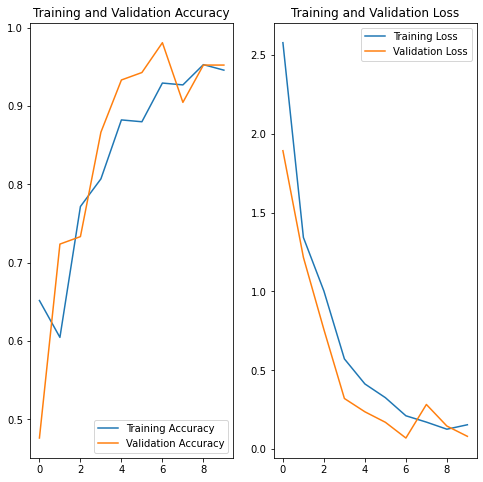

In [11]:
acc = trained_model.history['accuracy']
val_acc = trained_model.history['val_accuracy']

loss=trained_model.history['loss']
val_loss=trained_model.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    directory='crop_test',
    classes=['ball', 'goal', 'robot'],
    target_size=(224, 224),
)

Found 51 images belonging to 3 classes.


In [27]:
model.evaluate(test_generator)

2/2 [==============================] - 0s 147ms/step - loss: 0.0670 - accuracy: 0.9804


[0.06695215404033661, 0.9803922176361084]

In [23]:
X, y = test_generator.next()

In [24]:
import pandas as pd

result = model.predict(X)
result = [[round(val) for val in x] for x in result]

correction = [all(val1 == val2) for val1, val2 in zip(result, y)]

df = pd.DataFrame(list(zip(result, y, correction)), columns=['predict', 'actual', 'correction'])
print(df.head())

print(df['correction'].value_counts())

      predict           actual  correction
0   [0, 0, 1]  [0.0, 0.0, 1.0]        True
1   [0, 0, 1]  [0.0, 0.0, 1.0]        True
2   [1, 0, 0]  [1.0, 0.0, 0.0]        True
3   [0, 0, 1]  [0.0, 0.0, 1.0]        True
4   [0, 1, 0]  [0.0, 1.0, 0.0]        True
5   [0, 0, 1]  [0.0, 0.0, 1.0]        True
6   [1, 0, 0]  [1.0, 0.0, 0.0]        True
7   [0, 0, 1]  [0.0, 0.0, 1.0]        True
8   [0, 0, 1]  [0.0, 0.0, 1.0]        True
9   [0, 0, 1]  [0.0, 0.0, 1.0]        True
10  [0, 0, 1]  [0.0, 0.0, 1.0]        True
11  [1, 0, 0]  [1.0, 0.0, 0.0]        True
12  [0, 0, 1]  [0.0, 0.0, 1.0]        True
13  [0, 0, 1]  [0.0, 0.0, 1.0]        True
14  [0, 0, 1]  [0.0, 0.0, 1.0]        True
15  [0, 0, 1]  [0.0, 0.0, 1.0]        True
16  [1, 0, 0]  [1.0, 0.0, 0.0]        True
17  [0, 0, 1]  [0.0, 0.0, 1.0]        True
18  [0, 1, 0]  [0.0, 1.0, 0.0]        True
19  [0, 0, 1]  [0.0, 0.0, 1.0]        True
20  [0, 0, 1]  [0.0, 0.0, 1.0]        True
21  [0, 0, 1]  [0.0, 0.0, 1.0]        True
22  [0, 0, 